# Imports

In [1]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


from keras.utils import to_categorical
from numpy import *
import numpy as np


from transformers import TFBertForSequenceClassification, AutoTokenizer
from datasets import Dataset, load_dataset


import matplotlib.pyplot as plt

# Classnames

In [3]:
raw_dataset = load_dataset("go_emotions")
print(raw_dataset)

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})


In [4]:
{'0': 'admiration',
 '1': 'amusement',
 '2': 'anger',
 '3': 'annoyance',
 '4': 'approval',
 '5': 'caring',
 '6': 'confusion',
 '7': 'curiosity',
 '8': 'desire',
 '9': 'disappointment',
 '10': 'disapproval',
 '11': 'disgust',
 '12': 'embarrassment',
 '13': 'excitement',
 '14': 'fear',
 '15': 'gratitude',
 '16': 'grief',
 '17': 'joy',
 '18': 'love',
 '19': 'nervousness',
 '20': 'optimism',
 '21': 'pride',
 '22': 'realization',
 '23': 'relief',
 '24': 'remorse',
 '25': 'sadness',
 '26': 'surprise',
 '27': 'neutral'}

{'0': 'admiration',
 '1': 'amusement',
 '2': 'anger',
 '3': 'annoyance',
 '4': 'approval',
 '5': 'caring',
 '6': 'confusion',
 '7': 'curiosity',
 '8': 'desire',
 '9': 'disappointment',
 '10': 'disapproval',
 '11': 'disgust',
 '12': 'embarrassment',
 '13': 'excitement',
 '14': 'fear',
 '15': 'gratitude',
 '16': 'grief',
 '17': 'joy',
 '18': 'love',
 '19': 'nervousness',
 '20': 'optimism',
 '21': 'pride',
 '22': 'realization',
 '23': 'relief',
 '24': 'remorse',
 '25': 'sadness',
 '26': 'surprise',
 '27': 'neutral'}

{'grief': 77, 'pride': 111, 'relief': 153, 'nervousness': 164, 'embarrassment': 303, 'remorse': 545, 'fear': 596, 'desire': 641, 'disgust': 793, 'excitement': 853, 'surprise': 1060, 'caring': 1087, 'realization': 1110, 'disappointment': 1269, 'sadness': 1326, 'confusion': 1368, 'joy': 1452, 'anger': 1567, 'optimism': 1581, 'disapproval': 2022, 'love': 2086, 'curiosity': 2191, 'amusement': 2328, 'annoyance': 2470, 'gratitude': 2662, 'approval': 2939, 'admiration': 4130, 'neutral': 14219}


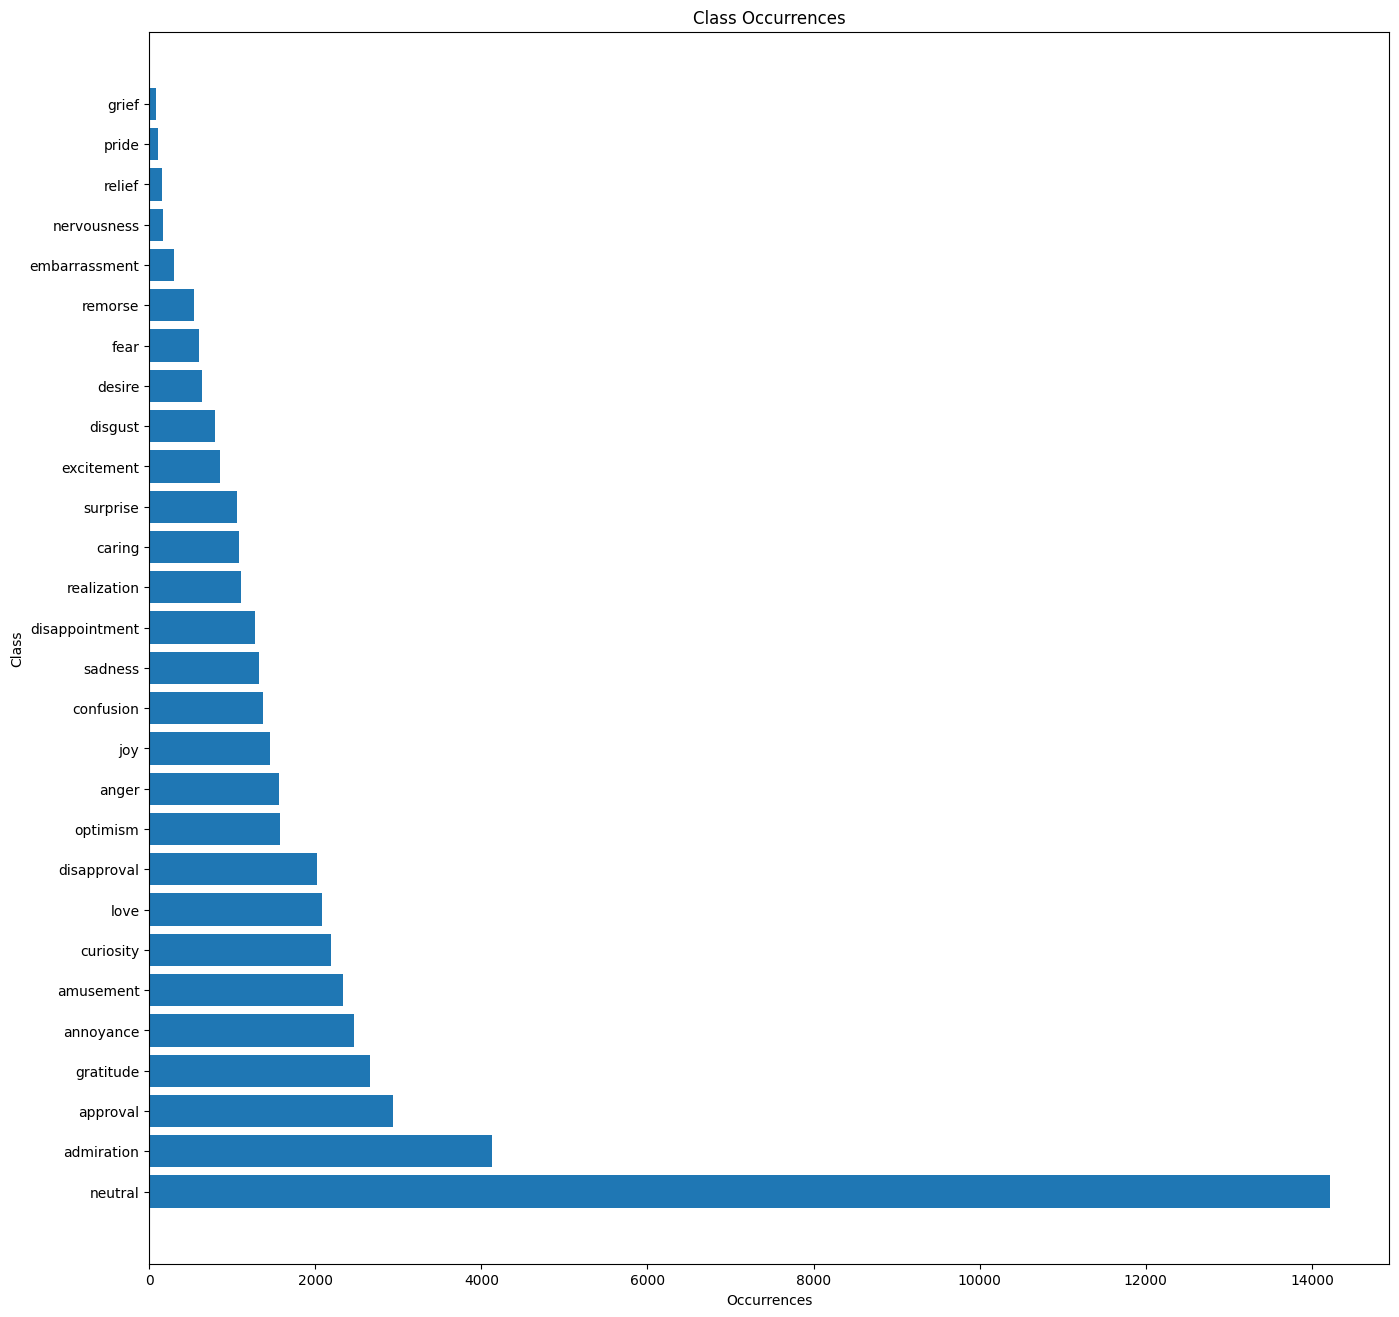

In [5]:
all_class_names = [
    "admiration",
    "amusement",
    "anger",
    "annoyance",
    "approval",
    "caring",
    "confusion",
    "curiosity",
    "desire",
    "disappointment",
    "disapproval",
    "disgust",
    "embarrassment",
    "excitement",
    "fear",
    "gratitude",
    "grief",
    "joy",
    "love",
    "nervousness",
    "optimism",
    "pride",
    "realization",
    "relief",
    "remorse",
    "sadness",
    "surprise",
    "neutral",
]

def count_classes(class_names):
    class_counts = {class_name: 0 for class_name in class_names}

    for item in raw_dataset['train']:
      for class_name in item['labels']:
            class_counts[all_class_names[class_name]] += 1
    return class_counts

feature_distribution = dict(sorted(count_classes(all_class_names).items(), key=lambda item: item[1])) 

print(feature_distribution)

def plot_class_occurrences(class_counts):
    # Get the class names and occurrence counts
    class_names = list(class_counts.keys())
    class_counts = list(class_counts.values())

    # Create a horizontal bar chart
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.barh(class_names, class_counts)

    # Set the axis labels and title
    ax.set_xlabel('Occurrences')
    ax.set_ylabel('Class')
    ax.set_title('Class Occurrences')

    # Invert the y-axis to show the classes in descending order of occurrences
    ax.invert_yaxis()

    # Show the plot
    plt.show()

plot_class_occurrences(feature_distribution)

In [6]:
class_names = list(feature_distribution.keys())[-14:]
class_name_idxs = [all_class_names.index(x) for x in class_names]

print(list(zip(class_names, class_name_idxs)))

[('sadness', 25), ('confusion', 6), ('joy', 17), ('anger', 2), ('optimism', 20), ('disapproval', 10), ('love', 18), ('curiosity', 7), ('amusement', 1), ('annoyance', 3), ('gratitude', 15), ('approval', 4), ('admiration', 0), ('neutral', 27)]


In [7]:
class_name_idxs

[25, 6, 17, 2, 20, 10, 18, 7, 1, 3, 15, 4, 0, 27]

# Dataset Stuff

In [8]:
def flatten_list(arr):
  return [num for sublist in arr for num in sublist]

In [9]:
def is_valid(data_item):
  return not (len(data_item["labels"]) == 1 and data_item["labels"][0] not in class_name_idxs)

def remove_invalid_classes(data_item):
  data_item["labels"] = [label for label in data_item["labels"] if label in class_name_idxs] # Remove invalid

  for label in data_item["labels"]:
    assert label in class_name_idxs

  data_item["labels"] = [class_name_idxs.index(label) for label in data_item["labels"]][0:1] # "Rename" old labels

  return data_item

def one_hot_labels(data_item):
  data_item["labels"] = sum(to_categorical(data_item["labels"], len(class_name_idxs)), axis = 0)
  return data_item

# Apply dataset processing
dataset = raw_dataset.filter(lambda x: is_valid(x)).map(remove_invalid_classes)

# One-hot the labels
dataset = dataset.map(one_hot_labels)

print(dataset)

Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

Map:   0%|          | 0/4756 [00:00<?, ? examples/s]

Map:   0%|          | 0/4728 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 38100
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 4756
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 4728
    })
})


# Hunspell

In [10]:
!apt-get install libhunspell-dev
!pip install hunspell

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libhunspell-dev is already the newest version (1.7.0-2build2).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import hunspell
import re

In [12]:
from tqdm import tqdm  # import tqdm

hobj = hunspell.HunSpell('/usr/share/hunspell/en_US.dic', '/usr/share/hunspell/en_US.aff')

# Define a function to correct misspelled words in a sentence
def correct_spelling(example):
    sentence = re.sub(r'[^\w\s]', '', example['text'])
    words = sentence.split()
    for j, word in enumerate(words):
        if not hobj.spell(word):
            # If word is misspelled, suggest corrections
            suggestions = hobj.suggest(word)
            if suggestions:
                # Replace misspelled word with first suggestion
                words[j] = suggestions[0]
    # Join the words back into a sentence and replace the original sentence in the dataset
    example['text'] = ' '.join(words)
    return example

# Apply the correction function to the entire train split using map with tqdm progress bar
corrected_dataset = dataset['train'].map(correct_spelling)

# Overwrite the original dataset 'train'
dataset['train'] = corrected_dataset

In [13]:
dataset['train']['text'][0] = ' '.join(["hi"])
print(dataset['train']['text'][0])

My favourite food is anything I didn't have to cook myself.


# Dataset Continued

In [14]:
sum(dataset["train"]["labels"], axis = 0)

array([ 1136,  1269,  1116,  1547,  1152,  1713,  1623,  1787,  2244,
        2138,  2158,  2596,  4130, 13168])

In [15]:
list(zip(dataset["train"]["text"][:5], dataset["train"]["labels"][:5]))

[("My favourite food is anything I didn't have to cook myself.",
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 ('Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead',
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 ('WHY THE FUCK IS BAYLESS ISOING',
  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 ('Dirty Southern Wankers', [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 ('Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝',
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])]

In [16]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

seq_lens = [len(tokenizer(x)["input_ids"]) for x in dataset["train"]["text"]]

seq_len = int(ceil(mean(seq_lens) + std(seq_lens)))

print(dataset['train']['text'][1])

def tokenize_dataset(data):
    # Keys of the returned dictionary will be added to the dataset as columns
    tokenizer_out = tokenizer(data["text"], padding = "max_length", truncation = True, max_length = seq_len) # Sets length of tokenized string to mean token sequence length
    for key in tokenizer_out:
      data[key] = tokenizer_out[key] # TODO: Once model training is working, see if "token_type_ids" and "attention_mask" are necessary (potentially reduce memory usage)
    return data

dataset_tokenized = dataset.map(tokenize_dataset)

print(dataset_tokenized)

Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead


Map:   0%|          | 0/38100 [00:00<?, ? examples/s]

Map:   0%|          | 0/4756 [00:00<?, ? examples/s]

Map:   0%|          | 0/4728 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 38100
    })
    validation: Dataset({
        features: ['text', 'labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4756
    })
    test: Dataset({
        features: ['text', 'labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4728
    })
})


[  3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  67  70  73  76  86  99 120 316]


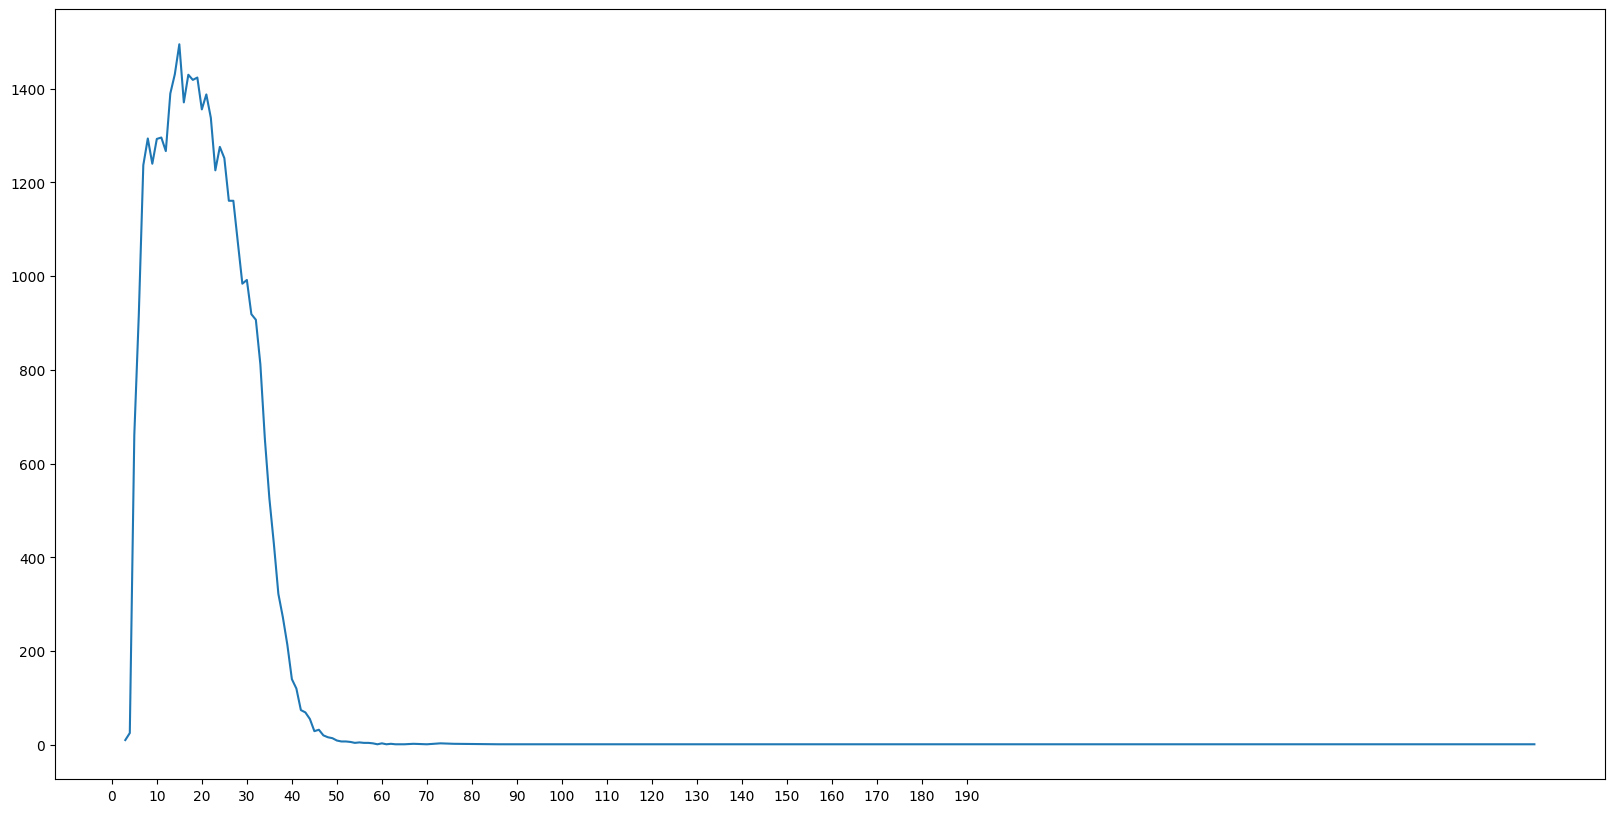

In [17]:
lens, counts = unique(seq_lens, return_counts = True)

figure, axis = plt.subplots(figsize = (20, 10))
axis.plot(lens, counts)
axis.set_xticks(range(0, 200, 10))
print(lens)

# Debug Functions

In [18]:
def labels_to_words(label_array):
  return [class_names[i] for i in range(14) if label_array[i] == 1] # Grab the classname for each index, if the label is active (1)

In [19]:
raw_dataset["train"][5]

{'text': "OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.",
 'labels': [26],
 'id': 'edvnz26'}

In [20]:
idx = 4
print(dataset_tokenized["train"][idx]["text"], dataset_tokenized["train"][idx]["labels"])

Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [21]:
# Checks to see if labels are correct for prompt
sample_data = dataset_tokenized["train"][random.randint(0, len(dataset_tokenized["train"]) - 1)]

print(sample_data["text"], labels_to_words(sample_data["labels"]))
print(sample_data["input_ids"])
print(sample_data["attention_mask"])

Love the [NAME]. They have a great dynamic and it looks like a genuine friendship. ['admiration']
[101, 2185, 1103, 164, 151, 10964, 2036, 166, 119, 1220, 1138, 170, 1632, 9652, 1105, 1122, 2736, 1176, 170, 10416, 7157, 119, 102, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


In [22]:
# Kierans Faves
# Reading this made me clutch my nipples in pain ['sadness']
# Hey! Go fuck yourself, you capitalist apologist bootlicking piece of shit ['anger']
# Well that's hardly this other woman's problem. You come across as a bitter, immature incel, so maybe sort your attitude out before trying to attract anyone. []
# Oh she dead ['amusement']

# Model

In [23]:
# Resets TF graph to release memory
tf.keras.backend.clear_session()

def define_model():
  input_ids = Input(shape = (seq_len,), dtype = "int32", name = "input_ids")
  token_type_ids = Input(shape = (seq_len,), dtype = "int32", name = "token_type_ids")
  attention_masks = Input(shape = (seq_len,), dtype = "int32", name = "attention_mask")

  bert = TFBertForSequenceClassification.from_pretrained("bert-base-cased", num_labels = 14)

  inputs = {"input_ids": input_ids, "attention_mask": attention_masks, "token_type_ids": token_type_ids}
  outputs = bert(inputs)
  model = outputs.logits
  
  model = Dense(14, activation = "softmax")(model)

  model = Model(inputs = [input_ids, token_type_ids, attention_masks], outputs = model)

  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

  model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

  return model

define_model().summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  108321038  ['attention_mask[0][0]',         
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'input_ids[0][0]',          

In [24]:
model = define_model()

batch_size = 128

tf_train_dataset = dataset_tokenized["train"].select(range(3000)).to_tf_dataset( # 1000 for speed debugging, for full training, comment out the ".select(n)"
  columns = ["input_ids", "token_type_ids", "attention_mask"],
  label_cols = ["labels"],
  batch_size = batch_size,
  shuffle = True,
)

tf_test_dataset = dataset_tokenized["test"].select(range(3000)).to_tf_dataset( # 1000 for speed debugging, for full training, comment out the ".select(n)"
  columns = ["input_ids", "token_type_ids", "attention_mask"],
  label_cols = ["labels"],
  batch_size = batch_size,
  shuffle = True,
)

red_lr = ReduceLROnPlateau(monitor = "val_accuracy", factor = 0.5, patience = 5)
early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 8, restore_best_weights = True)

history = model.fit(tf_train_dataset, validation_data = tf_test_dataset, epochs = 100, callbacks = [red_lr]).history
# history = model.fit(tf_train_dataset, validation_data = tf_test_dataset, epochs = 100, callbacks = [red_lr, early_stopping]).history

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100


InternalError: ignored

# Evaluation

## Display Functions

In [ ]:
def plot_graphs(vals, name, y_lim = 99999, y_scale = "linear", legend = []):
  """
  vals : list[list]
    a list of (a list of values for each epoch) - default expects [train values, test values]
  name : str
    name of type of values (goes on y-axis) eg "loss", "accuracy"
  y_lim : int
    greatest value on y axis is min(y_lim, max value in vals)
  y_scale : str
    controls scale of y-axis eg "linear", "logarithmic
  legend : list[str]
    allows for a custom legend
  """
  for val in vals:
    plt.plot(val)

  plt.ylabel(name)
  plt.xlabel("epoch")
  plt.xlim(0, len(vals[0]) - 1)
  if y_scale == "linear":
    plt.ylim(min(0, array(vals).min()), min(y_lim, array(vals).max()))
  plt.yscale(y_scale)

  if len(legend) > 0:
    plt.legend(legend)
  else:
    plt.legend(["train", "test"])

  plt.show()

  print(['{:.2e}'.format(v[-1]) for v in vals])

## Graphs

In [ ]:
plot_graphs([history["loss"], history["val_loss"]], "loss", y_scale = "log")
plot_graphs([history["accuracy"], history["val_accuracy"]], "accuracy")
plot_graphs([history["lr"]], "learning_rate", legend = ["lr"], y_scale = "log")

## Next Bit

In [ ]:
test_sample = list(tf_test_dataset.take(10))[1]
test_data, test_labels = test_sample

predictions = model.predict(test_data)

# raw_counts = unique(flatten_list([[j for j in range(14) if l[j] == 1] for l in test_labels]), return_counts = True)[1]

plt.plot(sum(around(predictions), axis = 0))
plt.plot(sum(test_labels, axis = 0))
plt.show()

incorrect_idxs = [i for i in range(batch_size) if prod(around(predictions) == test_labels, axis = 1)[i] == 1]

i_labels, i_counts = unique(flatten_list([[j for j in range(14) if test_labels[i].numpy()[j] == 1] for i in incorrect_idxs]), return_counts = True)

figure, axis = plt.subplots(figsize = (20, 5))
axis.plot(i_labels, i_counts)
plt.show()